# EGN6217 P3

In [2]:
!pip install transformers diffusers datasets

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ----------------------------------- ---- 3.1/3.6 MB 20.5 MB/s eta 0:00:01
   ---------------------------------------- 3.6/3.6 MB 17.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import torch
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from transformers import CLIPTokenizer
from diffusers import StableDiffusionPipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import random
from datasets import load_dataset
import ast
import re
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO
import hashlib
from torch.cuda.amp import GradScaler, autocast
from google.colab import drive
from IPython.display import clear_output
import textwrap

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## Raw Data Loading

In [ ]:
# load raw dataset

N_SUBSET = 1000 ####################

dataset = load_dataset("OpenFace-CQUPT/FaceCaption-15M")
train_dataset = dataset["train"].select(range(int(0.8*N_SUBSET)))         # 80% of n_subset
test_dataset = dataset['train'].select(range(int(0.8*N_SUBSET),N_SUBSET)) # 20% of n_subset

train_dataset = train_dataset.to_pandas()
test_dataset  = test_dataset.to_pandas()

train_dataset.head(3)

,_id,image,image_id,caption,pcfg,url,domain,sha256,box,laion_caption
0,651d16795982cc779aebdcff,split_00000/0000000010.jpg,split_00000_0000000010,"[He is young, with a 5 o'clock shadow, black h...","[he is young., he has 5 o clock shadow and bla...",http://cdn.pastemagazine.com/www/articles/2011...,cdn.pastemagazine.com,6561021576f886c0334b06955cea13e973101f296e0280...,"[43, 0, 299, 320]",[Ben Affleck Could Be Latest Addition To <em>T...
1,651d16795982cc779aebdd00,split_00000/0007830050.jpg,split_00000_0007830050,[The young woman is wearing lipstick and has a...,"[this person is wearing lipstick, she is mouth...",https://images.squarespace-cdn.com/content/523...,images.squarespace-cdn.com,96a4a35f111d1f37c9a00284d297d61becb5b0d01c4205...,"[252, 444, 508, 736]",[Bride and groom cutting cake]
2,651d16795982cc779aebdd01,split_00000/0000000080.jpg,split_00000_0000000080,"[She has a small open mouth, is young, adorned...","[she is mouth slightly open and young, she is ...",https://images.squarespace-cdn.com/content/502...,images.squarespace-cdn.com,7c60ed74cf5002d934adec487ceeb0f4848bfccecb5c57...,"[281, 313, 509, 642]",[Iowa City Engagement Session by St Louis Wedd...


In [ ]:
# display example
idx = random.randint(0, 100)
train_dataset["url"][idx], train_dataset["caption"][idx][0], train_dataset["box"][idx]

('https://cdn3.volusion.com/t5h6r.4srq5/v/vspfiles/photos/VU-208663-1.jpg?v-cache=1593829361, https://imgv1.face-caption.com/split_00000/000000069.jpg',
 'She is young, with a hat and lipstick on, and has big lips, no beard, and pale skin.',
 '[0, 0, 300, 300]')

## Raw Data Preprocessing

In [ ]:
# basic preprocessing

# pull captions out of inner array
train_dataset["caption"] = [caption[0] for caption in train_dataset["caption"]]
test_dataset["caption"] = [caption[0] for caption in test_dataset["caption"]]

# convert bounding boxes to arrays rather than strings
train_dataset["box"] = train_dataset["box"].apply(lambda x: ast.literal_eval(x))
test_dataset["box"] = test_dataset["box"].apply(lambda x: ast.literal_eval(x))

# preprocess captions
def preprocess_caption(caption):
    caption = caption.strip()
    caption = re.sub(r"[^a-zA-Z0-9\s.,!?()'-]", '', caption)
    caption = re.sub(r"\s+", ' ', caption)
    words = caption.split()[:77] # Stable Diffusion v1.5 uses CLIP which truncates at 77 tokens
    return ' '.join(words)
train_dataset["caption"] = [preprocess_caption(caption) for caption in train_dataset["caption"]]
test_dataset["caption"] = [preprocess_caption(caption) for caption in test_dataset["caption"]]

# split URL on comma and only keep first one
train_dataset["url"] = train_dataset["url"].str.replace(" ", "").str.split(",").str[0]
test_dataset["url"] = test_dataset["url"].str.replace(" ", "").str.split(",").str[0]

In [ ]:
# display example again
idx = random.randint(0, 100)
train_dataset["url"][idx], train_dataset["caption"][idx], train_dataset["box"][idx]

('https://cdn.shopify.com/s/files/1/2228/7757/products/IMG_5500_1024x1024.jpg?v=1571611019',
 'She is wearing earrings and sporting a youthful appearance, with a slightly open mouth and a warm smile. Her eyes are bags under them, her lips are full, her cheekbones are high, her eyes are narrow, and she has no beard or receding hairline.',
 [223, 51, 399, 271])

## Data Preprocessing

In [ ]:
# pull out useful vars from DataFrames

train_xs = train_dataset["caption"]  # img descriptions
train_ts_url = train_dataset["url"]  # img urls
train_ts_bbox = train_dataset["box"] # img bounding box coords

test_xs = test_dataset["caption"]  # ditto
test_ts_url = test_dataset["url"]  # ditto
test_ts_bbox = test_dataset["box"] # ditto

len(train_xs), len(test_xs)

(800, 200)

In [ ]:
# load, preprocess, and save raw imgs in memory
# (prevents network bottlenecks)

def preprocess_imgs(ts_url, ts_bbox, save_dir):
    def _transform(t, t_bbox):
        t = t.crop(t_bbox) # grab face
        t = t.resize((512, 512), Image.BILINEAR)
        t = transforms.ToTensor()(t)
        t = transforms.Normalize([0.5]*3, [0.5]*3)(t) # Stable Diffusion v1.5 uses these values
        return t

    ts_path = []
    dropped_idxs = []
    fail_count = 0

    os.makedirs(save_dir, exist_ok=True)
    for idx, (t_url, t_bbox) in enumerate(zip(ts_url, ts_bbox)):
        try:
            filename = str(idx) + ".pt"
            filepath = os.path.join(save_dir, filename)

            response = requests.get(t_url, timeout=5)
            response.raise_for_status()
            t = Image.open(BytesIO(response.content))
            t = t.convert("RGBA").convert("RGB") if t.mode == "P" else t # handle imgs w/ transparency
            t = _transform(t, t_bbox)

            torch.save(t, filepath) #################### t.half() for float16
            ts_path.append(filepath)
        except Exception as e:
            # print(f"[{idx}] Failed to process: {e}")
            dropped_idxs.append(idx)
            fail_count += 1
            pass

    print(f"{len(ts_url)-fail_count}/{len(ts_url)} images successfully processed")
    return ts_path, dropped_idxs

train_ts_path, train_dropped_idxs = preprocess_imgs(train_dataset["url"], train_dataset["box"], "/content/drive/MyDrive/Colab Data/egn6217-p3/train")
test_ts_path, test_dropped_idxs = preprocess_imgs(test_dataset["url"], test_dataset["box"], "/content/drive/MyDrive/Colab Data/egn6217-p3/test")

612/800 images successfully processed
157/200 images successfully processed


In [ ]:
# remove captions corresponding to invalid imgs

train_xs = train_xs.drop(train_dropped_idxs).reset_index(drop=True)
test_xs  = test_xs.drop(test_dropped_idxs).reset_index(drop=True)

assert len(train_xs) == len(train_ts_path)
assert len(test_xs)  == len(test_ts_path)

In [ ]:
class FaceCaption15MDataset(Dataset): # dynamic loading for training
    def __init__(self, xs, ts_paths):
        # set img stuff
        self.xs = xs             # img descriptions
        self.ts_paths = ts_paths # img paths

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        # load img stuff
        x = self.xs[idx]                   # img description
        t = torch.load(self.ts_paths[idx]) # img
        return x, t

def collate_fn(batch): # dynamic batch-wise tokenization
    xs, ts = zip(*batch)
    xs = tokenizer(xs, padding="longest", truncation=True, max_length=77, return_tensors="pt")
    ts = torch.stack(ts, dim=0)
    return xs, ts

In [ ]:
# create torch Datasets
train_dataset = FaceCaption15MDataset(train_xs, train_ts_path)
test_dataset = FaceCaption15MDataset(test_xs, test_ts_path)

len(train_dataset), len(test_dataset)

(612, 157)

In [ ]:
warnings.filterwarnings("ignore")

# # save torch Datasets
# torch.save(train_dataset, "/content/drive/MyDrive/Colab Data/egn6217-p3/train_dataset.pth")
# torch.save(test_dataset, "/content/drive/MyDrive/Colab Data/egn6217-p3/test_dataset.pth")

# load torch Datasets
train_dataset = torch.load("/content/drive/MyDrive/Colab Data/egn6217-p3/train_dataset.pth", weights_only=False)
test_dataset = torch.load("/content/drive/MyDrive/Colab Data/egn6217-p3/test_dataset.pth", weights_only=False)

In [ ]:
# create torch DataLoaders
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14") # in Stable Diffusion v1.5 architecture, imported separately here for collate_fn
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, collate_fn=collate_fn, pin_memory=True) ######################## high n_workers high pin_memory = faster compute but more used memory
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, collate_fn=collate_fn, pin_memory=True)   ######################## high n_workers high pin_memory = faster compute but more used memory

len(train_loader), len(test_loader)

(39, 10)

In [ ]:
# display info

warnings.filterwarnings("ignore")

# display the tokenized caption lengths per batch
i = 1
for xs, ts in train_loader:
    if i > 2:
        break
    print(f"BATCH {i}")
    print(f"Caption lengths: {len(xs.input_ids[0])}, {len(xs.input_ids[1])}, {len(xs.input_ids[2])}, ...\n")
    i += 1

# display the caption data format
for xs, ts in train_loader:
    print(f"BATCH 1\nCaption examples: {xs}")
    break

BATCH 1
Caption lengths: 56, 56, 56, ...

BATCH 2
Caption lengths: 53, 53, 53, ...

BATCH 1
Caption examples: {'input_ids': tensor([[49406,  1043,   533,  1888,   537, 25743, 13392,   267, 44953,   593,
          4200,  5853,   267,  9136,   267, 15618,   267,   537,   320, 16306,
          8231,   267,   537,   791,  1449,  2225,   593,   871,  9052,   537,
         31941, 13212,   269, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407],
        [49406,  1043,   533,  1888,   267,   593,  1205,  8847,   267,   320,
          1205,  8231,   267,  1449,  2225,   267,  1400, 40000,  9476,   267,
           871,  9052,   267,   537, 31941,  2225,   269, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407],
        [49406,   797,  

## Training

Stable Diffusion Inference Breakdown:
1. Encode the text prompt w/ CLIP
2. Generate random latent noise
3. Given the noise and encoded text, use U-Net and a scheduler to run denoising steps of repeatedly predicting and subtracting noise, producing a "clean" latent
5. Use VAE to decode the clean latent to a final image

Stable Diffusion Training Breakdown:
1. Encode ground truth image into latent space with the VAE encoder, producing the clean latent that is normally decoded by the VAE in step 5 above
2. Generate random latent noise and add it to the "clean" latent, simulating some point in the U-Net's denoising
3. Encode the text prompt w/ CLIP
4. Given the encoded text and ground truth image with noise, use U-Net to run denoising steps (specifically predicting the noise) and update U-Net with error from the predicted noise and the step 2 ground-truth noise that we know was added to the real image

VRAM Savings Strategies:
- Load entire model as float16
- Use n_workers=0 and pin_memory=False in DataLoaders, saving compute/VRAM but taking longer
- Enable attention slicing in training
- Enable gradient checkpointing in training
- Unfortunately, VAE component should stay float32
- Convert resulting latent imgs and caption embeddings back to float16 for U-Net

In [ ]:
diffusion_pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32) ######################## torch.float16

loss_fn = F.mse_loss
optimizer = torch.optim.AdamW(diffusion_pipe.unet.parameters(), lr=1e-5, weight_decay=0.01)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def train(pipe, train_loader, loss_fn, optimizer, n_epochs):
    warnings.filterwarnings('ignore')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipe = pipe.to(device)

    scaler = GradScaler() ######################## scaler/autocast code adjusts between float32<-->float16 for memory and compute improvements

    # pipe.enable_attention_slicing("max")      ######################## splits attention computation, less used memory but slower compute
    # pipe.unet.enable_gradient_checkpointing() ######################## recomputes activations on-the-fly during backprop instead of storing, less used memory but slower compute

    pipe.text_encoder.eval() # freeze CLIP
    pipe.unet.train()        # unfreeze U-Net (only component to train)
    pipe.vae.eval()          # freeze VAE

    LC_train = []

    print(f"Beginning training on {device}...")

    for epoch in range(n_epochs):

        torch.set_grad_enabled(True)
        train_loss = 0.0

        for xs, ts in tqdm(train_loader, desc=f"Epoch {epoch+1}"): # tdqm prints progress bar

            xs_mask = xs["attention_mask"]
            xs = xs["input_ids"]

            xs_mask = xs_mask.to(device)
            xs = xs.to(device)
            ts = ts.to(device)

            with autocast(): ########################
                # forward propagation

                # encode ground truth imgs to latent space
                with torch.no_grad():
                    ts_latent = pipe.vae.encode(ts).latent_dist.sample()
                    ts_latent = ts_latent * 0.18215  # Stable Diffusion v1.5 uses this scaling factor

                # generate random noise and timesteps
                noise = torch.randn_like(ts_latent)
                timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps,(ts_latent.shape[0],), device=device).long()

                # add noise to latent ground truth imgs
                ts_latent = pipe.scheduler.add_noise(ts_latent, noise, timesteps)

                # encode captions with CLIP
                with torch.no_grad():
                    xs_encoded = pipe.text_encoder(input_ids=xs, attention_mask=xs_mask)[0]

                # predict noise with U-Net
                noise_pred = pipe.unet(sample=ts_latent, timestep=timesteps, encoder_hidden_states=xs_encoded).sample

                loss = loss_fn(noise_pred, noise)
            train_loss += loss.item() # batch avg

            # back propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward() ########################
            scaler.step(optimizer)        ########################
            scaler.update()               ########################
            # loss.backward()
            # optimizer.step()

            del xs_mask, xs, ts, ts_latent, noise, timesteps, xs_encoded, noise_pred, loss
            # torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)
        LC_train.append(avg_train_loss)
        print(f'EPOCH {epoch+1:3d} || AVG TRAIN LOSS: {avg_train_loss:.4f}')

    pipe = pipe.to("cpu")
    return pipe, LC_train

In [ ]:
diffusion_pipe, LC_train = train(diffusion_pipe, train_loader, loss_fn, optimizer, 15)
diffusion_pipe.save_pretrained("/content/drive/MyDrive/Colab Data/egn6217-p3/diffusion_pipe")

Beginning training on cuda...


Epoch 1: 100%|██████████| 39/39 [00:41<00:00,  1.06s/it]


EPOCH   1 || AVG TRAIN LOSS: 0.1408


Epoch 2: 100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


EPOCH   2 || AVG TRAIN LOSS: 0.1356


Epoch 3: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH   3 || AVG TRAIN LOSS: 0.1423


Epoch 4: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH   4 || AVG TRAIN LOSS: 0.1395


Epoch 5: 100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


EPOCH   5 || AVG TRAIN LOSS: 0.1434


Epoch 6: 100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


EPOCH   6 || AVG TRAIN LOSS: 0.1335


Epoch 7: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH   7 || AVG TRAIN LOSS: 0.1412


Epoch 8: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH   8 || AVG TRAIN LOSS: 0.1264


Epoch 9: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH   9 || AVG TRAIN LOSS: 0.1404


Epoch 10: 100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


EPOCH  10 || AVG TRAIN LOSS: 0.1463


Epoch 11: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH  11 || AVG TRAIN LOSS: 0.1335


Epoch 12: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH  12 || AVG TRAIN LOSS: 0.1316


Epoch 13: 100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


EPOCH  13 || AVG TRAIN LOSS: 0.1316


Epoch 14: 100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


EPOCH  14 || AVG TRAIN LOSS: 0.1331


Epoch 15: 100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


EPOCH  15 || AVG TRAIN LOSS: 0.1374


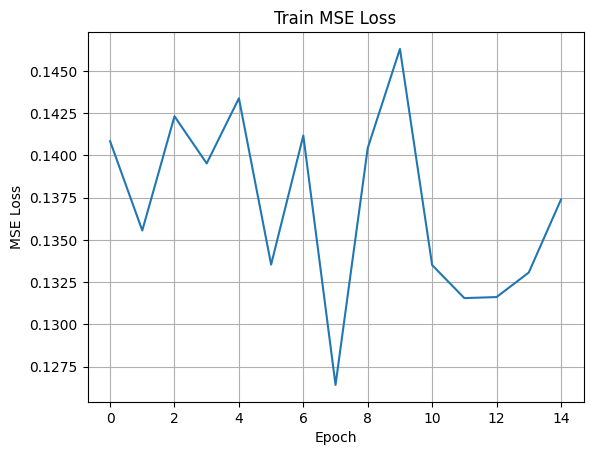

In [ ]:
# plot LC
plt.plot(LC_train)
plt.title("Train MSE Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

## Testing

In [ ]:
# re-setup environment

warnings.filterwarnings("ignore")

# tokenizer, model, loss function
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14") # in Stable Diffusion v1.5 architecture, imported separately here for collate_fn
diffusion_pipe = StableDiffusionPipeline.from_pretrained("/content/drive/MyDrive/Colab Data/egn6217-p3/diffusion_pipe", torch_dtype=torch.float32) ######################## torch.float16
loss_fn = F.mse_loss

# tokenizer, Dataset and DataLoader

class FaceCaption15MDataset(Dataset): # dynamic loading for training
    def __init__(self, xs, ts_paths):
        # set img stuff
        self.xs = xs             # img descriptions
        self.ts_paths = ts_paths # img paths

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        # load img stuff
        x = self.xs[idx]                   # img description
        t = torch.load(self.ts_paths[idx]) # img
        return x, t

def collate_fn(batch): # dynamic batch-wise tokenization
    xs, ts = zip(*batch)
    xs = tokenizer(xs, padding="longest", truncation=True, max_length=77, return_tensors="pt")
    ts = torch.stack(ts, dim=0)
    return xs, ts

test_dataset = torch.load("/content/drive/MyDrive/Colab Data/egn6217-p3/test_dataset.pth", weights_only=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, collate_fn=collate_fn, pin_memory=True) ######################## high n_workers high pin_memory = faster compute but more used memory

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def test(pipe, test_loader, loss_fn):
    warnings.filterwarnings('ignore')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipe = pipe.to(device)

    # pipe.enable_attention_slicing("max")      ######################## splits attention computation, less used memory but slower compute

    pipe.text_encoder.eval() # freeze CLIP
    pipe.unet.eval()         # freeze U-Net
    pipe.vae.eval()          # freeze VAE
    torch.set_grad_enabled(False)

    print(f"Beginning testing on {device}...")

    test_loss = 0.0

    for xs, ts in tqdm(test_loader, desc="Testing"):

        xs_mask = xs["attention_mask"]
        xs = xs["input_ids"]

        xs_mask = xs_mask.to(device)
        xs = xs.to(device)
        ts = ts.to(device)

        with autocast(): ########################
            # forward pass

            # encode ground truth imgs to latent space
            ts_latent = pipe.vae.encode(ts).latent_dist.sample()
            ts_latent = ts_latent * 0.18215

            # generate random noise and timesteps
            noise = torch.randn_like(ts_latent)
            timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (ts_latent.shape[0],), device=device).long()

            # add noise to latent ground truth imgs
            ts_latent = pipe.scheduler.add_noise(ts_latent, noise, timesteps)

            # encode captions with CLIP
            xs_encoded = pipe.text_encoder(input_ids=xs, attention_mask=xs_mask)[0]

            # predict noise with U-Net
            noise_pred = pipe.unet(sample=ts_latent, timestep=timesteps, encoder_hidden_states=xs_encoded).sample

            loss = loss_fn(noise_pred, noise)
            test_loss += loss.item()

        del xs_mask, xs, ts, ts_latent, noise, timesteps, xs_encoded, noise_pred, loss
        # torch.cuda.empty_cache()

    avg_test_loss = test_loss / len(test_loader)
    print(f'AVG TEST LOSS: {avg_test_loss:.4f}')

    pipe = pipe.to("cpu")

In [ ]:
test(diffusion_pipe, test_loader, loss_fn)

Beginning testing on cuda...


Testing: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]


AVG TEST LOSS: 0.1265


In [ ]:
def eval_truth_pretrained_tuned(pipe_pretrained, pipe_tuned, test_dataset, n_samples=5):
  '''For first n_samples of test_dataset, outputs the ground truth img with caption,
  pretrained diffusion's img, and tuned diffusion's img.'''

  def _unnormalize(t):
    return t*0.5 + 0.5

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  pipe_pretrained = pipe_pretrained.to(device)
  pipe_tuned = pipe_tuned.to(device)

  # to_pil = transforms.ToPILImage()

  fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

  for n in range(n_samples):

    # get str caption and tensor img
    x, t = test_dataset[n]

    # generate imgs
    t = np.array(_unnormalize(t).permute(1, 2, 0)) # unnormalize ground truth tensor img, permute, and convert to numpy
    t_pretrained = pipe_pretrained(prompt=x, guidance_scale=15).images[0]
    t_tuned = pipe_tuned(prompt=x, guidance_scale=15).images[0]

    axes[n, 0].imshow(t)
    axes[n, 0].set_title(f"[{n+1}] Ground Truth Img")
    axes[n, 0].axis("off")

    axes[n, 1].imshow(t_pretrained)
    axes[n, 1].set_title(f"[{n+1}] Pretrained Diffusion Img")
    caption = "\n".join(textwrap.wrap(x, width=120))
    axes[n, 1].set_xlabel(f"Caption: {caption}")
    axes[n, 1].tick_params(axis='x', which='both', bottom=False)
    axes[n, 1].tick_params(axis='y', which='both', bottom=False)

    axes[n, 2].imshow(t_tuned)
    axes[n, 2].set_title(f"[{n+1}] Tuned Diffusion Img")
    axes[n, 2].axis("off")

  clear_output(wait=True)

  plt.tight_layout()
  plt.show()

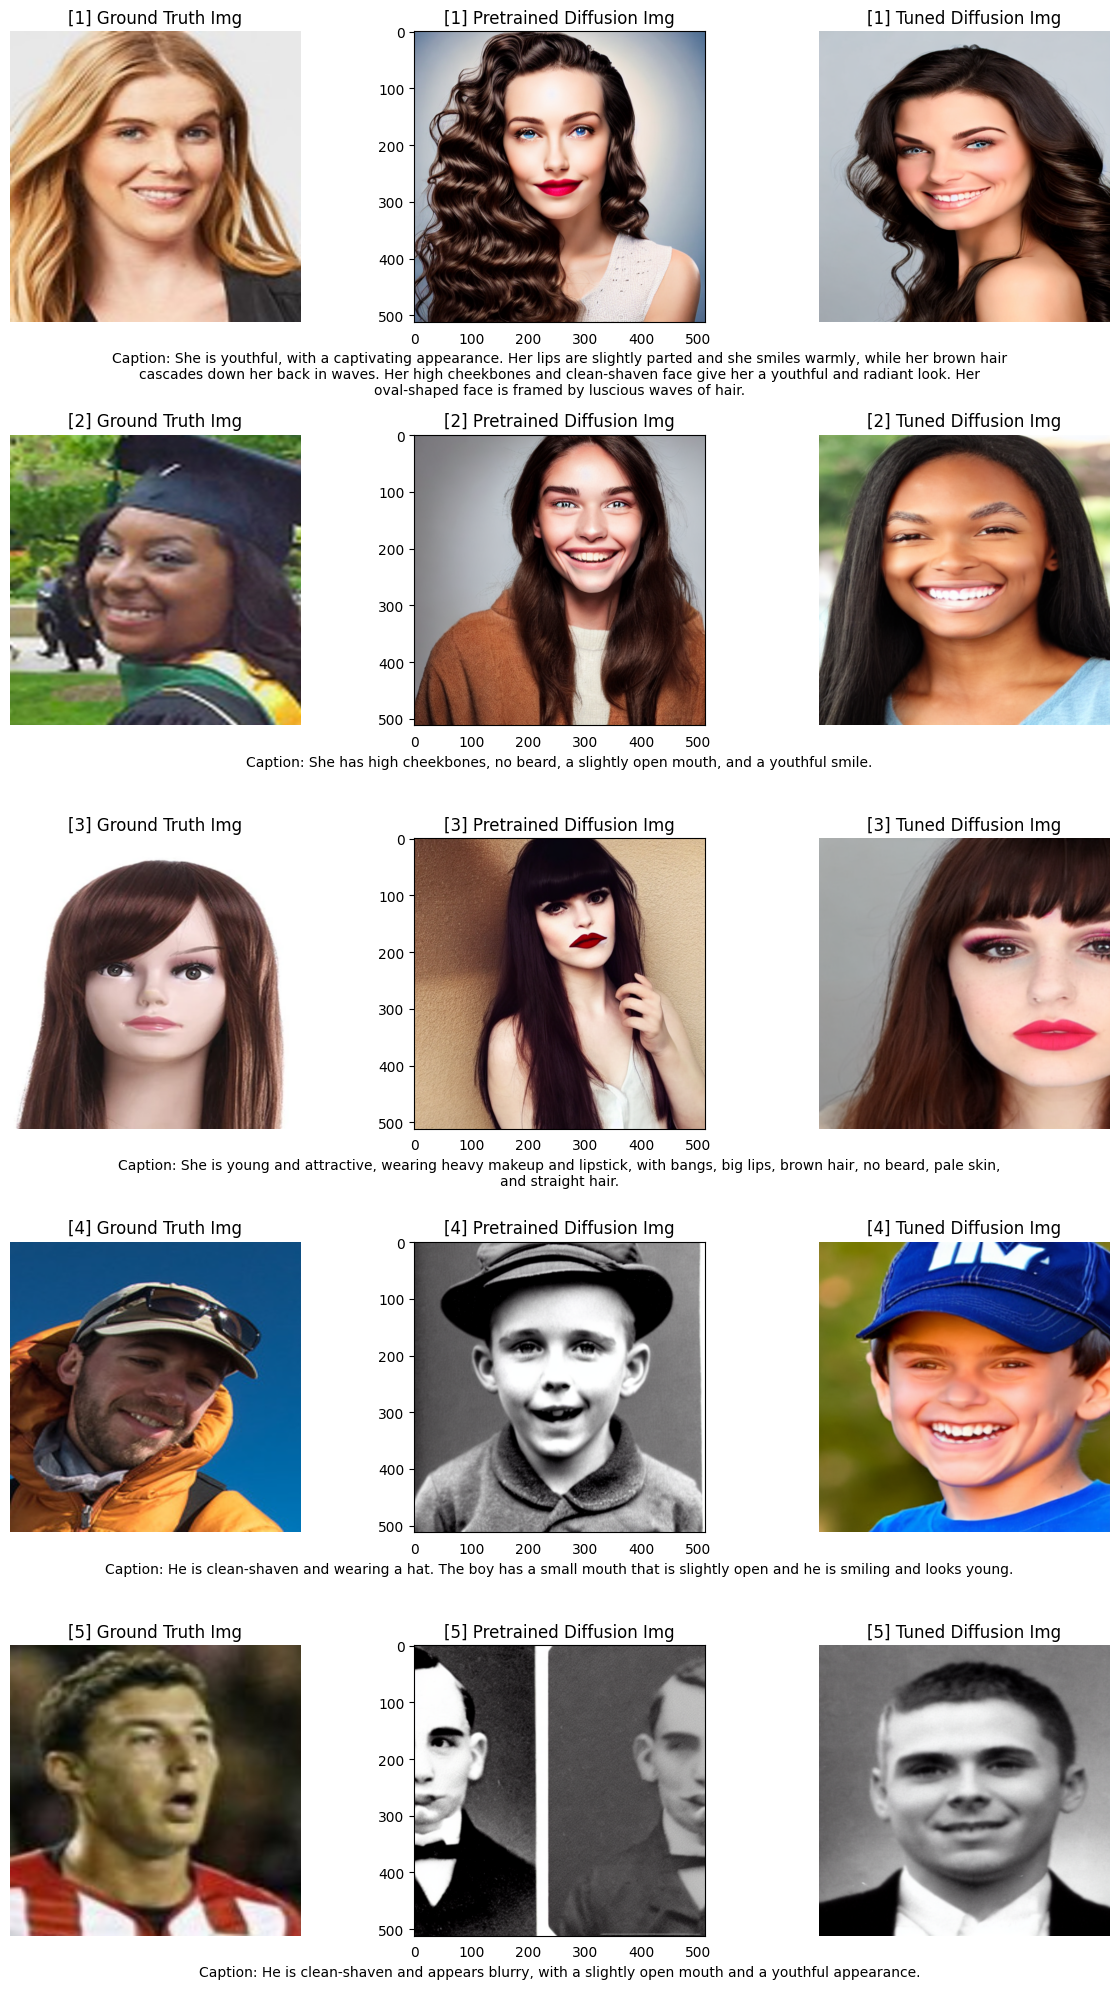

In [ ]:
diffusion_pipe_pretrained = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32) ######################## torch.float16
eval_truth_pretrained_tuned(diffusion_pipe_pretrained, diffusion_pipe, test_dataset, n_samples=5)

Need To Do:
- Make end-to-end notebook w/ Gradio interface to use both models

Potential Improvements:
- Get better-captioned data, maybe use raw face dataset w/ CLIP-generated captions?
- Use bigger train dataset, LoRA modules, learning rate scheduler, early stopping, etc. to improve training
- Explore what parameters influence creativity of generated image
- Consider lightweight speech-to-text model over Wav2Vec